# Introduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

**What?** Storage Benchmark

</font>
</div>

# Available storage formats
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>


- **CSV**: Comma-separated, standard flat text file format.

- **HDF5**: Hierarchical data format, developed initially at the National Center for Supercomputing Applications. It is a fast and scalable storage format for numerical data, available in pandas using the PyTables library.

- **Parquet**: Part of the Apache Hadoop ecosystem, a binary, columnar storage format that provides efficient data compression and encoding and has been developed by Cloudera and Twitter. It is available for pandas through the `pyarrow` library.

</font>
</div>

# Imports
<hr style = "border:2px solid black" ></hr>

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## Generate Test Data


<div class="alert alert-info">
<font color=black>

- The test `DataFrame` that can be configured to contain numerical or text data, or both. 
- Run this twice with the following settings:
    - `data_type='Numeric: numerical_cols=2000, text_cols=0`
    - `data_type='Mixed: numerical_cols=1000, text_cols=1000`

    
</font>
</div>

In [2]:
results = {}

In [3]:
def generate_test_data(nrows=100000, numerical_cols=2000, text_cols=0, text_length=10):
    s = "".join([random.choice(string.ascii_letters)
                 for _ in range(text_length)])
    data = pd.concat([pd.DataFrame(np.random.random(size=(nrows, numerical_cols))),
                      pd.DataFrame(np.full(shape=(nrows, text_cols), fill_value=s))],
                     axis=1, ignore_index=True)
    data.columns = [str(i) for i in data.columns]
    return data

In [4]:
# Change these
data_type = 'Mixed'
df = generate_test_data(numerical_cols=2000, text_cols=1000)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 3000 entries, 0 to 2999
dtypes: float64(2000), object(1000)
memory usage: 2.2+ GB


## Parquet

### Size

In [6]:
parquet_file = Path('test.parquet')

In [7]:
df.to_parquet(parquet_file)
size = parquet_file.stat().st_size

### Read

In [8]:
%%timeit -o
df = pd.read_parquet(parquet_file)

11.4 s ± 1.61 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 11.4 s ± 1.61 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [9]:
read = _

In [10]:
parquet_file.unlink()

### Write

In [11]:
%%timeit -o
df.to_parquet(parquet_file)
parquet_file.unlink()

44.6 s ± 8.52 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 44.6 s ± 8.52 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [12]:
write = _

### Results

In [13]:
results['Parquet'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

## HDF5

In [14]:
test_store = Path('index.h5')

### Fixed Format

#### Size

In [15]:
with pd.HDFStore(test_store) as store:
    store.put('file', df)
size = test_store.stat().st_size

#### Read

In [16]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    store.get('file')

4min 47s ± 5.98 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 4min 47s ± 5.98 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [17]:
read = _

In [18]:
test_store.unlink()

#### Write

In [19]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    store.put('file', df)
test_store.unlink()

1min 42s ± 7.93 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1min 42s ± 7.93 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [20]:
write = _

#### Results

In [21]:
results['HDF Fixed'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

### Table Format

#### Size

In [22]:
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t')
size = test_store.stat().st_size    

#### Read

In [23]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    df = store.get('file')

2min 6s ± 4.64 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 2min 6s ± 4.64 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [24]:
read = _

In [25]:
test_store.unlink()

#### Write

Note that `write` in table format does not work with text data.

In [26]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t')
test_store.unlink()    

2min 34s ± 4.76 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 2min 34s ± 4.76 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [27]:
write = _

#### Results

In [28]:
results['HDF Table'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

### Table Select

#### Size

In [29]:
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t', data_columns=['company', 'form'])
size = test_store.stat().st_size 

#### Read

In [30]:
company = 'APPLE INC'

In [31]:
%%timeit
with pd.HDFStore(test_store) as store:
    s = store.get('file')

2min 4s ± 3.33 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
read = _

In [33]:
test_store.unlink()

#### Write

In [34]:
%%timeit
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t', data_columns=['company', 'form'])
test_store.unlink() 

2min 32s ± 3.32 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
write = _

#### Results

In [36]:
results['HDF Select'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

## CSV

In [37]:
test_csv = Path('test.csv')

### Size

In [38]:
df.to_csv(test_csv)
test_csv.stat().st_size

4954570636

### Read

In [39]:
%%timeit -o
df = pd.read_csv(test_csv)

56.6 s ± 683 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 56.6 s ± 683 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [40]:
read = _

In [41]:
test_csv.unlink()  

### Write

In [42]:
%%timeit -o
df.to_csv(test_csv)
test_csv.unlink()

4min 21s ± 1.27 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 4min 21s ± 1.27 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [43]:
write = _

### Results

In [44]:
results['CSV'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

## Store Results

In [45]:
pd.DataFrame(results).assign(Data=data_type).to_csv(f'{data_type}.csv')

## Display Results

Please run the notebook twice as described above under `Usage` to create the two `csv` files with results for different test data.

In [49]:
df = (pd.read_csv('Numeric.csv', index_col=0)
      .append(pd.read_csv('Mixed.csv', index_col=0))
      .rename(columns=str.capitalize))
df.index.name='Storage'
df = df.set_index('Data', append=True).unstack()
"""df.size /= 1e9"""

'df.size /= 1e9'

In [51]:
df

Parquet                   Hdf fixed                   Hdf table  \
Data            Mixed       Numeric         Mixed       Numeric         Mixed   
Storage                                                                         
read     1.136848e+01  2.930570e+00  2.873654e+02  5.259554e+00  1.260325e+02   
size     2.027396e+09  2.026791e+09  2.902261e+09  1.600821e+09  2.601136e+09   
write    4.463071e+01  1.187686e+01  1.029682e+02  6.013046e+00  1.541750e+02   

                         Hdf select                         Csv                
Data          Numeric         Mixed       Numeric         Mixed       Numeric  
Storage                                                                        
read     1.023441e+00  1.541750e+02  5.007504e+00  5.655696e+01  3.328696e+01  
size     1.601034e+09  2.601136e+09  1.601034e+09  2.601136e+09  1.601034e+09  
write    5.007504e+00  1.541750e+02  5.007504e+00  2.615256e+02  2.276563e+02

KeyError: 'Read'

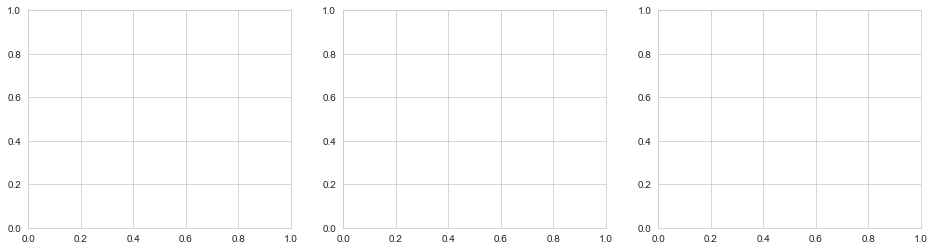

In [50]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
for i, op in enumerate(['Read', 'Write', 'Size']):
    flag= op in ['Read', 'Write']
    df.loc[:, op].plot.barh(title=op, ax=axes[i], logx=flag)
    if flag:
        axes[i].set_xlabel('seconds (log scale)')
    else:
        axes[i].set_xlabel('GB')
fig.tight_layout()
fig.savefig('storage', dpi=300);

# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

- [GitHub code](https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/02_market_and_fundamental_data/05_storage_benchmark/storage_benchmark.ipynb)

</font>
</div>